In [1]:
# this avoids broken pipes by making the default system handler handle the SIGPIPE call
# see https://stackoverflow.com/questions/14207708/ioerror-errno-32-broken-pipe-python
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE, SIG_DFL)

<Handlers.SIG_IGN: 1>

# Project-similar exercise in BLAST
I want to find all the human and non-human Kunitz-containing proteins in SwissProt.
I will use the non-human ones as a positive in the training set.
I will generate a random set of proteins as a negative set, of the same size of the positive set.
Finally, I will remove the training set from UniProt and perform a prediction based on a Blast Search.

## Find human and non-human Kunitz proteins in SwissProt
I search on Uniprot all the human proteins in SwissProt containing the Kunitz domain.

`reviewed:yes organism:"Homo sapiens (Human) [9606]" database:(type:pfam PF00014)`

I retrieve 18 proteins. I download them in Fasta format.

In [2]:
!head human_SP_Kunitz.fasta

>sp|Q06481|APLP2_HUMAN Amyloid-like protein 2 OS=Homo sapiens OX=9606 GN=APLP2 PE=1 SV=2
MAATGTAAAAATGRLLLLLLVGLTAPALALAGYIEALAANAGTGFAVAEPQIAMFCGKLN
MHVNIQTGKWEPDPTGTKSCFETKEEVLQYCQEMYPELQITNVMEANQRVSIDNWCRRDK
KQCKSRFVTPFKCLVGEFVSDVLLVPEKCQFFHKERMEVCENHQHWHTVVKEACLTQGMT
LYSYGMLLPCGVDQFHGTEYVCCPQTKIIGSVSKEEEEEDEEEEEEEDEEEDYDVYKSEF
PTEADLEDFTEAAVDEDDEDEEEGEEVVEDRDYYYDTFKGDDYNEENPTEPGSDGTMSDK
EITHDVKAVCSQEAMTGPCRAVMPRWYFDLSKGKCVRFIYGGCGGNRNNFESEDYCMAVC
KAMIPPTPLPTNDVDVYFETSADDNEHARFQKAKEQLEIRHRNRMDRVKKEWEEAELQAK
NLPKAERQTLIQHFQAMVKALEKEAASEKQQLVETHLARVEAMLNDRRRMALENYLAALQ
SDPPRPHRILQALRRYVRAENKDRLHTIRHYQHVLAVDPEKAAQMKSQVMTHLHVIEERR


In [3]:
!cat human_SP_Kunitz.fasta|grep ">"|wc -l

18


I search on Uniprot all the non-human proteins in SwissProt containing the Kunitz domain.

`database:(type:pfam pf00014) NOT organism:"Homo sapiens (Human) [9606]" AND reviewed:yes`

I retrieve 341 proteins. I download them in Fasta format.

In [4]:
!head no_human_SP_Kunitz.fasta

>sp|P08592|A4_RAT Amyloid-beta A4 protein OS=Rattus norvegicus OX=10116 GN=App PE=1 SV=2
MLPSLALLLLAAWTVRALEVPTDGNAGLLAEPQIAMFCGKLNMHMNVQNGKWESDPSGTK
TCIGTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHTHIVIPYRCLVG
EFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFR
GVEFVCCPLAEESDSIDSADAEEDDSDVWWGGADTDYADGGEDKVVEVAEEEEVADVEEE
EAEDDEDVEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPC
RAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSVSSQSLLKTTSEPLPQD
PVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQA
KNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITAL
QAVPPRPHHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYER


In [5]:
!cat no_human_SP_Kunitz.fasta|grep ">"|wc -l

341


I search on Uniprot all the human proteins in SwissProt NOT containing the Kunitz domain.

`NOT database:(type:pfam pf00014) AND organism:"Homo sapiens (Human) [9606]" AND reviewed:yes`

I retrieve 20347 proteins. I download them in Fasta format.

In [6]:
!head human_SP_no_Kunitz.fasta

>sp|Q8N8B7|TEANC_HUMAN Transcription elongation factor A N-terminal and central domain-containing protein OS=Homo sapiens OX=9606 GN=TCEANC PE=1 SV=2
MSDKNQIAARASLIEQLMSKRNFEDLGNHLTELETIYVTKEHLQETDVVRAVYRVLKNCP
SVALKKKAKCLLSKWKAVYKQTHSKARNSPKLFPVRGNKEENSGPSHDPSQNETLGICSS
NSLSSQDVAKLSEMIVPENRAIQLKPKEEHFGDGDPESTGKRSSELLDPTTPMRTKCIEL
LYAALTSSSTDQPKADLWQNFAREIEEHVFTLYSKNIKKYKTCIRSKVANLKNPRNSHLQ
QNLLSGTTSPREFAEMTVMEMANKELKQLRASYTESCIQEHYLPQVIDGTQTNKIKCRRC
EKYNCKVTVIDRGTLFLPSWVRNSNPDEQMMTYVICNECGEQWYHSKWVCW
>sp|O75494|SRS10_HUMAN Serine/arginine-rich splicing factor 10 OS=Homo sapiens OX=9606 GN=SRSF10 PE=1 SV=1
MSRYLRPPNTSLFVRNVADDTRSEDLRREFGRYGPIVDVYVPLDFYTRRPRGFAYVQFED
VRDAEDALHNLDRKWICGRQIEIQFAQGDRKTPNQMKAKEGRNVYSSSRYDDYDRYRRSR


In [7]:
!cat human_SP_no_Kunitz.fasta|grep ">"|wc -l

20347


# Create BLAST database
I create the blast database for the human SP proteins set. I decided to use the new version of BLAST, differently from the professor.

In [8]:
!makeblastdb -in human_SP_Kunitz.fasta -dbtype prot



Building a new DB, current time: 04/20/2020 09:50:01
New DB name:   /home/saul/currently_working/LB1/exercises/8_blast_Kunitz/human_SP_Kunitz.fasta
New DB title:  human_SP_Kunitz.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/saul/currently_working/LB1/exercises/8_blast_Kunitz/human_SP_Kunitz.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 18 sequences in 0.00696707 seconds.


# Create the training and testing sets
The negative database `human_SP_no_Kunitz.fasta` contains 20347 proteins

In [9]:
!grep ">" human_SP_no_Kunitz.fasta|wc -l

20347


I want to split it more or less in half, so I decide to split at the 10000th sequence included.
Now I want to determine at which line of the file shuold I split

In [10]:
!grep ">" human_SP_no_Kunitz.fasta -m 10000|tail -1
!grep ">" human_SP_no_Kunitz.fasta -m 10001 -n|tail -1

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
109075:>sp|P32970|CD70_HUMAN CD70 antigen OS=Homo sapiens OX=9606 GN=CD70 PE=1 SV=2


The 10000th protein, O95081, ends at line 109074 (1 minus where the next sequence starts)
Now I split my negative database .

In [11]:
!head -n 109074 human_SP_no_Kunitz.fasta  > human_SP_no_Kunitz_Training.fasta
!tail  -n +109075 human_SP_no_Kunitz.fasta  > human_SP_no_Kunitz_Testing.fasta
!grep ">" human_SP_no_Kunitz_Training.fasta|tail -1
!cat human_SP_no_Kunitz_Testing.fasta|head -1

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
>sp|P32970|CD70_HUMAN CD70 antigen OS=Homo sapiens OX=9606 GN=CD70 PE=1 SV=2


## Training and testing for the positives
Professors used the same set for both training and testing (!) the positives.
I will split them to do things better.
The procedure is the same used for the negatives.
The positive set is composed of not-human proteins with Kunitz domain.

In [12]:
!grep ">" no_human_SP_Kunitz.fasta|wc -l

341


I want to split it more or less in half, so I decide to split at the 10000th sequence included.
Now I want to determine at which line of the file shuold I split

In [13]:
!grep ">" human_SP_no_Kunitz.fasta -m 10000|tail -1
!grep ">" human_SP_no_Kunitz.fasta -m 10001 -n|tail -1

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
109075:>sp|P32970|CD70_HUMAN CD70 antigen OS=Homo sapiens OX=9606 GN=CD70 PE=1 SV=2


The 10000th protein, O95081, ends at line 109074 (1 minus where the next sequence starts)
Now I split my negative database .

In [14]:
!head -n 109074 human_SP_no_Kunitz.fasta  > human_SP_no_Kunitz_Training.fasta
!tail  -n +109075 human_SP_no_Kunitz.fasta  > human_SP_no_Kunitz_Testing.fasta
!grep ">" human_SP_no_Kunitz_Training.fasta|tail -1
!cat human_SP_no_Kunitz_Testing.fasta|head -1

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
>sp|P32970|CD70_HUMAN CD70 antigen OS=Homo sapiens OX=9606 GN=CD70 PE=1 SV=2


In the negative training set I have 10000 proteins, and 10347 in the testing set.

In [15]:
!grep ">" human_SP_no_Kunitz_Training.fasta|wc -l
!grep ">" human_SP_no_Kunitz_Testing.fasta|wc -l

10000
10347


# Blasting the database against itself
I BLAST the positive set agaist itself for seeing what will be the range of E-value that I get. I increse the E-value threshold just for fun.

In [16]:
!#blastp -query human_SP_Kunitz.fasta -db human_SP_Kunitz.fasta -out autotest.bltab -outfmt 6 -evalue 1000 # -m 8 of the old version7

These are the lines in which the first 2 columns are equal, and so they are self-matches.

In [17]:
!awk '{if ($1==$2) print $0}' autotest.bltab

sp|Q06481|APLP2_HUMAN	sp|Q06481|APLP2_HUMAN	100.000	763	0	0	1	763	1	763	0.0	1590
sp|P05067|A4_HUMAN	sp|P05067|A4_HUMAN	100.000	770	0	0	1	770	1	770	0.0	1610
sp|Q02388|CO7A1_HUMAN	sp|Q02388|CO7A1_HUMAN	100.000	2944	0	0	1	2944	1	2944	0.0	5494
sp|P12111|CO6A3_HUMAN	sp|P12111|CO6A3_HUMAN	100.000	3177	0	0	1	3177	1	3177	0.0	6455
sp|P02760|AMBP_HUMAN	sp|P02760|AMBP_HUMAN	100.000	352	0	0	1	352	1	352	0.0	734
sp|O95925|EPPI_HUMAN	sp|O95925|EPPI_HUMAN	100.000	133	0	0	1	133	1	133	8.42e-100	274
sp|P10646|TFPI1_HUMAN	sp|P10646|TFPI1_HUMAN	100.000	304	0	0	1	304	1	304	0.0	630
sp|O43278|SPIT1_HUMAN	sp|O43278|SPIT1_HUMAN	100.000	529	0	0	1	529	1	529	0.0	1099
sp|O43291|SPIT2_HUMAN	sp|O43291|SPIT2_HUMAN	100.000	252	0	0	1	252	1	252	0.0	521
sp|P48307|TFPI2_HUMAN	sp|P48307|TFPI2_HUMAN	100.000	235	0	0	1	235	1	235	2.53e-180	486
sp|Q8TEU8|WFKN2_HUMAN	sp|Q8TEU8|WFKN2_HUMAN	100.000	576	0	0	1	576	1	576	0.0	1199
sp|Q2UY09|COSA1_HUMAN	sp|Q2UY09|COSA1_HUMAN	100.000	1125	0	0	1	1125	1	1125	0.0	2187
sp|Q96NZ8|WFKN1_HUMAN	

I sort the results of BLAST on column 11, so to reverse-order by E-value.

In [18]:
!sort -grk 11 autotest.bltab|head

sp|P48307|TFPI2_HUMAN	sp|P05067|A4_HUMAN	27.273	11	8	0	154	164	551	561	999	11.5
sp|P05067|A4_HUMAN	sp|P12111|CO6A3_HUMAN	22.222	45	33	1	251	295	1752	1794	999	13.5
sp|O95925|EPPI_HUMAN	sp|O43278|SPIT1_HUMAN	30.000	10	7	0	56	65	432	441	999	10.8
sp|Q8TEU8|WFKN2_HUMAN	sp|Q02388|CO7A1_HUMAN	37.500	16	10	0	97	112	2341	2356	998	13.1
sp|Q2UY09|COSA1_HUMAN	sp|Q02388|CO7A1_HUMAN	54.545	11	5	0	495	505	932	942	998	13.9
sp|Q2UY09|COSA1_HUMAN	sp|P12111|CO6A3_HUMAN	50.000	10	5	0	279	288	134	143	998	13.9
sp|Q02388|CO7A1_HUMAN	sp|P49223|SPIT3_HUMAN	38.462	13	8	0	1425	1437	32	44	998	15.0
sp|P48307|TFPI2_HUMAN	sp|P02760|AMBP_HUMAN	23.810	21	16	0	164	184	72	92	997	11.5
sp|O43291|SPIT2_HUMAN	sp|O95428|PPN_HUMAN	40.000	15	9	0	60	74	178	192	996	11.5
sp|P12111|CO6A3_HUMAN	sp|O95428|PPN_HUMAN	71.429	7	2	0	2160	2166	983	989	995	15.4


# Training

## Positive training set
Now I BLAST the positive training set (not human Kunitz).
It is slow, don't run just for fun. This is why I am commenting it.
I sort by best E-value and print the first proteins.

In [19]:
!#blastp -query no_human_SP_Kunitz.fasta -db human_SP_Kunitz.fasta -out positive_training.bltab -outfmt 6

In [20]:
!sort -gk 11 positive_training_testing.bltab|head

sp|P00978|AMBP_BOVIN	sp|P02760|AMBP_HUMAN	77.273	352	80	0	1	352	1	352	0.0	561
sp|P04366|AMBP_PIG	sp|P02760|AMBP_HUMAN	80.655	336	65	0	2	337	17	352	0.0	581
sp|P08592|A4_RAT	sp|P05067|A4_HUMAN	96.883	770	24	0	1	770	1	770	0.0	1557
sp|P08592|A4_RAT	sp|Q06481|APLP2_HUMAN	49.873	790	320	17	3	769	26	762	0.0	716
sp|P0C5J5|WFKN1_RAT	sp|Q8TEU8|WFKN2_HUMAN	56.691	538	209	8	31	550	41	572	0.0	607
sp|P0C5J5|WFKN1_RAT	sp|Q96NZ8|WFKN1_HUMAN	87.992	533	63	1	20	552	17	548	0.0	939
sp|P12023|A4_MOUSE	sp|P05067|A4_HUMAN	96.623	770	26	0	1	770	1	770	0.0	1551
sp|P12023|A4_MOUSE	sp|Q06481|APLP2_HUMAN	50.253	790	317	17	3	769	26	762	0.0	721
sp|P15943|APLP2_RAT	sp|Q06481|APLP2_HUMAN	92.318	742	51	2	26	765	26	763	0.0	1340
sp|P15989|CO6A3_CHICK	sp|P12111|CO6A3_HUMAN	65.153	2884	977	11	1	2873	1	2867	0.0	3726


For each protein in the query, I want to find the best E-value possible.
I create an awk array with the first column as index, so to collapse duplicates and store the best E-value.
I output an identical bltab file but filtered to have just the best match for each sequence.
The filtered output contains 341 alignments, which is the same number of the number of unique indentifiers in the original file.

In [21]:
!cat positive_training_testing.bltab|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> positive_training_testing_topscores.bltab

In [22]:
!cat positive_training_testing_topscores.bltab|sort -rgk 11|head # worst best scores for each sequence
!wc -l positive_training_testing_topscores.bltab
!cat positive_training_testing.bltab|awk '{print $1}'|sort -u|wc -l #number of unique queries in the original BLAST output

sp|D3GGZ8|BLI5_HAECO	sp|Q2UY09|COSA1_HUMAN	23.944	71	41	4	125	191	1062	1123	0.045	25.0
sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
341 positive_training_testing_topscores.bltab
341


## Summary of positive training
The worst top score for a sequence in the positive training set is 0.045, followed by e-04 and e-07.
In total I have 341 unique sequences in the query.

## Negative training set
Now I BLAST the negative training set (human not Kunitz training).
It is slow, don't run just for fun. This is why I am commenting it.
I sort by best E-value and print the first proteins.
I need to set an high E-value threshold otherwise I don't get an hit for all the sequences.
However, even with a 1000 thershold I am still missing 2 sequences (9998 unique hits).
I will never be able to compute with an higher threshold.

In [23]:
!#blastp -query human_SP_no_Kunitz_Training.fasta -db human_SP_Kunitz.fasta -out negative_training.bltab -outfmt 6 -evalue 100

In [24]:
!sort -gk 11 negative_training.bltab|head

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	28.559	1194	795	25	26	1181	38	1211	5.81e-140	480
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	27.288	1180	802	28	29	1172	38	1197	2.94e-121	421
sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	28.182	1100	704	31	226	1272	36	1102	2.43e-110	385
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326


The first 2 sequences are strange. They have 0 E-value and their names seem to be really similar.

For each protein in the query, I want to find the best E-value possible.
I create an awk array with the first column as index, so to collapse duplicates and store the best E-value.
I output an identical bltab file but filtered to have just the best match for each sequence.
The filtered output contains 9998 alignments, which is the same number of the number of unique indentifiers in the original file.

In [25]:
!cat negative_training.bltab|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> negative_training_topscores.bltab

In [26]:
!cat negative_training_topscores.bltab|sort -gk 11|head # best E-values of the negatives
!wc -l negative_training_topscores.bltab
!cat negative_training.bltab|awk '{print $1}'|sort -u|wc -l #number of unique queries in the original BLAST output

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326
sp|Q05707|COEA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.752	891	550	26	148	1019	28	870	4.38e-94	330
sp|Q99715|COCA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.604	1026	643	34	1192	2180	31	1024	7.58e-92	325
sp|Q9UKP4|ATS7_HUMAN	sp|O95428|PPN_HUMAN	41.761	443	233	13	541	974	29	455	9.88e-89	308
9998 negative_training_topscores.bltab
9998


## Summary of negative training
The top score for a sequence in the negative training set is 0, and there are many scores around e-100.

# Finding the thresholds
Now I play with the E-value thresholds on the positive set to see how many true positive I can catch with different thresholds.
I work with the topscores files so that it is quicker.
I am actually intersted at the best alignment for each sequence.
I use awk for filtering.
Setting 10 as a threshold I get all the 341 proteins, while setting 0.001 I get 340 of them, loosing the one with E-value of 0.045.
Note that the only meaningful value is that under the E-value threshold, not above.
This is because I can have as many hits as I want above!
However, If I take the best it for each sequence the total number of hits is the same af the number of sequences, so I can also use the above-threshold value.

In [27]:
!cat positive_training_testing_topscores.bltab|awk '{if ($11<10) print $0}'|sort -rgk 11|head
!cat positive_training_testing_topscores.bltab|awk '{if ($11<10) print $0}'|wc -lc

sp|D3GGZ8|BLI5_HAECO	sp|Q2UY09|COSA1_HUMAN	23.944	71	41	4	125	191	1062	1123	0.045	25.0
sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
    341   29315


In [28]:
!cat positive_training_testing_topscores.bltab|awk '{if ($11<1e-03) print $0}'|sort -rgk 11|head
!cat positive_training_testing_topscores.bltab|awk '{if ($11<1e-03) print $0}'|wc -l

sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
sp|P0DMW9|VKT34_ACTEQ	sp|O43291|SPIT2_HUMAN	51.429	35	17	0	3	37	35	69	1.39e-11	47.4
340


I can do the same with the negative training set. I want the number of proteins with E-value lower than the threshold to be as low as possible.

In [29]:
!cat negative_training_topscores.bltab|awk '{if ($11<1e-03) print $0}'|sort -gk 11|head
!cat negative_training_topscores.bltab|awk '{if ($11<1e-03) print $0}'|wc -l

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326
sp|Q05707|COEA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.752	891	550	26	148	1019	28	870	4.38e-94	330
sp|Q99715|COCA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.604	1026	643	34	1192	2180	31	1024	7.58e-92	325
sp|Q9UKP4|ATS7_HUMAN	sp|O95428|PPN_HUMAN	41.761	443	233	13	541	974	29	455	9.88e-89	308
302


Now I play with different levels and see what happens. The numbers are:
* true positives
* true negatives-2 (9998 instead of 10000 sequences in the blast output)
* false negatives
* false positives

Threshold too high: I catch all the true positives but miss all the true negatives

In [30]:
%%bash
THRESHOLD=10000
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives-2

341
0
0
9998


Threshold too low: I catch all the true negatives but miss all the true positives

In [31]:
%%bash
THRESHOLD=-1
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives-2
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives

0
9998
341
0


1e-03 for instance seems reasonable

In [32]:
%%bash
THRESHOLD=1e-03
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives-2
cat positive_training_testing_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives

340
9696
1
302


# Confusion matrix, Matthews correlation coefficient, and Accuracy
I will do this in python since it is easier to manipulate matrices.

## Pre-processing
Let's first defain our input files.
I will use the files which were already filtered so to have only the best hit for each query sequence.

In [33]:
# the positive training set (that is also testing set in our case, we didn't have enough proteins)
p_train_path = "./positive_training_testing_topscores.bltab"

# the negative training set
n_train_path = "./negative_training_topscores.bltab"

I could take my data and painfully parse it, but why not to just use pandas and have them ready?
I create a function that gives me a pandas dataframe from the filepath and then I call it on both inputs.

In [34]:
import pandas as pd

def get_blasttab_df(blasttab_path):
    with open(blasttab_path) as blasttab_file:
        blasttab_df = pd.read_csv(blasttab_file, sep="\s+", header=None)
    return blasttab_df

p_train_df = get_blasttab_df(p_train_path)
n_train_df = get_blasttab_df(n_train_path)

So now I have all the file content in a beatiful pandas dataframe. I print them here so that I know what they contain and I can look at it while working with the data. Note that pandas already converted all the column in the proper type (int, float, string).

In [35]:
p_train_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,sp|B6RLX2|VKTCT_OPHHA,sp|P12111|CO6A3_HUMAN,43.103,58,33,0,24,81,3105,3162,3.980000e-18,68.2
1,sp|A6MGY1|VKT7_DEMVE,sp|P12111|CO6A3_HUMAN,50.000,54,27,0,29,82,3110,3163,5.090000e-19,70.9
2,sp|P00992|VKT3_VIPAA,sp|P10646|TFPI1_HUMAN,43.860,57,32,0,25,81,119,175,1.820000e-19,72.0
3,sp|B5L5Q6|VKT5_OXYMI,sp|Q96NZ8|WFKN1_HUMAN,52.174,46,22,0,33,78,361,406,6.440000e-14,56.2
4,sp|P62756|IATR_CAPHI,sp|P02760|AMBP_HUMAN,84.553,123,19,0,1,123,227,349,1.960000e-77,224.0
...,...,...,...,...,...,...,...,...,...,...,...,...
336,sp|P0C1X2|VKTS1_CONST,sp|P10646|TFPI1_HUMAN,45.902,61,33,0,23,83,207,267,2.160000e-13,54.7
337,sp|Q6T6S5|VKT2_BITGA,sp|P10646|TFPI1_HUMAN,49.123,57,29,0,25,81,119,175,4.680000e-19,70.5
338,sp|P0DN11|VKT7_ANEVI,sp|O43291|SPIT2_HUMAN,46.377,69,37,0,10,78,27,95,4.640000e-19,69.7
339,sp|P0DMJ6|VKT12_DENAN,sp|P10646|TFPI1_HUMAN,44.828,58,31,1,1,58,49,105,5.740000e-17,63.5


In [36]:
n_train_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,sp|P16455|MGMT_HUMAN,sp|P12111|CO6A3_HUMAN,42.857,28,13,2,177,204,2326,2350,2.600000e-01,22.7
1,sp|Q8N136|DAW1_HUMAN,sp|P12111|CO6A3_HUMAN,28.000,50,31,1,317,361,750,799,9.800000e-02,25.4
2,sp|Q7Z7L8|CK096_HUMAN,sp|Q02388|CO7A1_HUMAN,53.333,15,7,0,289,303,221,235,1.300000e+01,18.5
3,sp|Q56NI9|ESCO2_HUMAN,sp|Q8TEU8|WFKN2_HUMAN,20.370,162,111,6,89,243,341,491,8.800000e-01,22.7
4,sp|Q1HG44|DOXA2_HUMAN,sp|O95428|PPN_HUMAN,37.778,45,23,2,274,315,301,343,3.200000e+00,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,sp|Q9BXJ1|C1QT1_HUMAN,sp|P12111|CO6A3_HUMAN,47.727,44,23,0,97,140,2111,2154,8.880000e-08,43.9
9994,sp|A6NCS6|CB072_HUMAN,sp|O95428|PPN_HUMAN,71.429,7,2,0,229,235,28,34,4.700000e+00,19.2
9995,sp|P21399|ACOC_HUMAN,sp|O95428|PPN_HUMAN,29.167,72,50,1,743,813,632,703,8.400000e-01,23.5
9996,sp|P63167|DYL1_HUMAN,sp|Q8TEU8|WFKN2_HUMAN,35.484,31,18,1,3,33,127,155,8.500000e-01,19.2


What really matters now is the E-value, not all the additional data.
I also need to remeber the number of total positives and total negatives in the training sets.
I re-calculate here for easier reference.

In [37]:
!cat no_human_SP_Kunitz.fasta|grep ">"|wc -l # total positives in training set

341


In [38]:
!cat human_SP_no_Kunitz_Training.fasta|grep ">"|wc -l # total negatives in training set

10000


It is not a given that in my output of BLAST I will have every sequence in the query.
BLAST only gives me the number of positives, not that of negatives.
I used a E-value threshold of 1000, but still 2 sequences from the negatives did not find any match.
For our purposes, I can just add to the arrays a number of values equal to the difference between the number of query sequences and the lenght of the array containing the unique sequences that blast produced.
These values are for sure higher than the threshold I used in the BLAST search, 1000.
So I can use 1000 as a value to add.
There is no need to do it for the whole dataframe.
From now on I operate only on the E-values.

First I define a function for completing the arrays with the missing values.
It takes as arguments the array of values and the number of total sequences in the BLAST query.
This is the lenght that I want my array to have.

In [39]:
import numpy as np

def blast_complete_array(e_val_arr, tot_expected):
    to_be_appended = [1000]*(tot_expected-len(e_val_arr))
    completed_arr = np.append(e_val_arr, to_be_appended, axis = 0)
    return completed_arr

Now I exctract an array containing only the E-values for both positives and negatives and I put it in a numpy array.
Here it is column 10 instead of 11 since pandas starts from 0.
I also call around them the function for completing the missing sequences, so I have complete arrays to work with.

In [40]:
p_train_vals = blast_complete_array(np.array(p_train_df[10]),341)
n_train_vals = blast_complete_array(np.array(n_train_df[10]),10000)

len(p_train_vals), len(n_train_vals)

(341, 10000)

Now my arrays look like this, and contain all the E-values for positives and negatives.

In [41]:
p_train_vals

array([3.98e-018, 5.09e-019, 1.82e-019, 6.44e-014, 1.96e-077, 2.30e-019,
       0.00e+000, 1.29e-056, 3.65e-015, 1.32e-016, 1.24e-019, 1.51e-016,
       5.54e-016, 8.61e-017, 2.67e-016, 7.06e-017, 4.62e-012, 5.03e-018,
       7.20e-019, 8.40e-033, 0.00e+000, 9.44e-013, 8.69e-030, 8.61e-017,
       1.60e-018, 1.60e-017, 7.07e-025, 8.08e-018, 2.42e-016, 1.86e-017,
       6.64e-017, 0.00e+000, 4.64e-012, 4.12e-017, 1.04e-012, 1.02e-090,
       5.74e-017, 3.70e-017, 1.16e-019, 6.24e-018, 7.55e-017, 6.49e-017,
       2.51e-016, 0.00e+000, 2.32e-018, 6.97e-018, 2.50e-020, 3.84e-016,
       7.91e-017, 5.01e-018, 7.83e-017, 1.85e-007, 7.03e-019, 3.18e-019,
       6.31e-010, 1.80e-015, 6.76e-017, 1.55e-018, 0.00e+000, 1.92e-013,
       2.91e-019, 1.83e-012, 1.85e-013, 1.33e-016, 1.86e-017, 1.09e-020,
       1.92e-018, 5.56e-035, 8.53e-019, 7.37e-018, 0.00e+000, 1.64e-014,
       1.73e-018, 2.44e-004, 3.54e-019, 7.99e-017, 2.16e-018, 0.00e+000,
       5.21e-017, 2.43e-018, 4.25e-018, 0.00e+000, 

In [42]:
n_train_vals

array([2.6e-01, 9.8e-02, 1.3e+01, ..., 2.3e+00, 1.0e+03, 1.0e+03])

## Confusion matrix
My aim now is to define a function for creating a confusion matrix from which I will calculate the Matthews correlation (MCC) and the accuracy (ACC).

In [43]:
def get_confusion_mat(thr, p_vals, n_vals):
    # I evaluate only below thresholds since only those are meaningful for blast (above I can have as many as I want!)
    true_pos_arr = p_vals[p_vals<thr] # np.arr<value returns an np.array with [True, False, True, ...]
    false_pos_arr = n_vals[n_vals<thr] # if I use it as an index for the array itself it filters only the values meeting the condition
    # the numerosity of a class is just the lenght of its array
    true_pos = len(true_pos_arr)
    false_pos = len(false_pos_arr)
    # I calculate the remaining class from the differences
    tot_p = len(p_vals)
    tot_n = len(n_vals)
    false_neg = tot_p - true_pos
    true_neg = tot_n - false_pos
    confusion_mat = np.array([[true_pos, false_pos],[true_neg, false_neg]])
    return confusion_mat

I just use a mock threshold of -1 now, so that all the proteins will be above it. I expect to have 100% of false negatives and of true positives.
In practice everithing will be negative.
This is just to test if myu function works as expected.

In [44]:
cm_0 = get_confusion_mat(-1, p_train_vals, n_train_vals)
cm_0

array([[    0,     0],
       [10000,   341]])

In the same way with a really high threshold I should have 100% true negatives and false positives

In [45]:
cm_inf = get_confusion_mat(np.infty, p_train_vals, n_train_vals)
cm_inf

array([[  341, 10000],
       [    0,     0]])

## Accuracy
I want to define functions that can calculate the ACC from a confusion matrix.

The formula of the ACC:

$$
ACC = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [46]:
def get_ACC(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    t_pos = confusion_mat[0][0]
    t_neg = confusion_mat[1][0]
    f_pos = confusion_mat[0][1]
    f_neg = confusion_mat[1][1]
    above_frac = t_pos+t_neg
    below_frac = t_pos+t_neg+f_pos+f_neg
    ACC = above_frac/below_frac
    return ACC

## Matthews Correlation Coefficient
I want to define functions that can calculate the MCC from a confusion matrix.

The formula of the MCC:

$$
MCC = \frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(TP*FN)*(TN+FP)*(TN+FN)}}
$$

In [47]:
def get_MCC(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    t_pos = confusion_mat[0][0]
    t_neg = confusion_mat[1][0]
    f_pos = confusion_mat[0][1]
    f_neg = confusion_mat[1][1]
    above_frac = t_pos*t_neg-f_pos*f_neg
    below_frac = np.sqrt((t_pos+f_pos)*(t_pos+f_neg)*(t_neg+f_pos)*(t_neg+f_neg))
    MCC = above_frac/max(below_frac,1) # otherwise I can divide by 0
    return MCC

## Testing MCC and ACC functions
I want to see if the functions I determined work as expected.
For making things easier, I wrap both of them in a single function that takes a threshold and the arrays of positives and negatives and prints the confusion matrix, the ACC, and the MCC.

In [48]:
def get_stats(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    ACC = get_ACC(thr, p_vals, n_vals)
    MCC = get_MCC(thr, p_vals, n_vals)
    print("Confusion matrix:\n")
    print(confusion_mat, "\n")
    print("Threshold:", thr)
    print("ACC:", ACC)
    print("MCC:", MCC)
    return confusion_mat, ACC, MCC

I can now try to compute the staistics for E-value threshold for which I know what the result should be, so that I can test if my functions work as expected.
With a threshold of -1, all the values will be above threshold and so I will have only negatives predicted.
I expect 100% true negatives and false negatives.
The MCC should be 0.

In [49]:
get_stats(-1, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[    0     0]
 [10000   341]] 

Threshold: -1
ACC: 0.9670244657189827
MCC: 0.0


In the same way with a threshold of infinite everithing will be within threshold.
I expect 100% true positives and false positives.
The MCC should be 0 also in this case.

In [50]:
get_stats(np.infty, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[  341 10000]
 [    0     0]] 

Threshold: inf
ACC: 0.03297553428101731
MCC: 0.0


With a more sensible threshold, like 1e-03, I expect an higher MCC.

In [51]:
get_stats(1e-03, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[ 340  302]
 [9698    1]] 

Threshold: 0.001
ACC: 0.9706991586887148
MCC: 0.7155057611301966


# Finding the best E-value threshold
I want to find the best E-value threshold for discriminating Kunitz and non-Kunitz proteins.
I will use the MCC as an unbiased measure of performance of my threshold.
Threfore, I want to find the threshold $\theta^*$ that maximizes the MCC, given the dataset D.

$$
\theta^* = argmax_\theta(|MCC(D, \theta)|)
$$

An MCC of 0 indicates random predictions, an MCC of 1 perfect predictions and an MCC of -1 perfect reverse predictions (always wrong).
Even perfect reverse predictions are ok for me, because I can just take the opposite of what my model says.
Threfore I want to maximise the absolute value of the MCC.
A good way to find the best $\theta$ could be to plot how the MCC varies with respect of $\theta$.
The best $\theta$ will be the one corresponding to a maximum of this function.
I can create a function that tryes a lot of different values of $\theta$ (i.e., in powers of 10 from $10^{-100}$ to 1) and plots the results on a graph.
This is essentially a linear regrssion algorithm.

Now I define a function that does just this.
Note that the argumets are the orders of magnitude that will be tried, not the actual thresholds.

In [52]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


def plot_MCC(p_vals, n_vals, low_bound=-100, up_bound=100, threshold=None):
    MCC_list = []
    ACC_list = []
    thr_list = list(np.logspace(low_bound, up_bound))
    for thr in thr_list:
        MCC = get_MCC(thr, p_vals, n_vals)
        ACC = get_ACC(thr, p_vals, n_vals)
        MCC_list.append(abs(MCC))
        ACC_list.append(abs(ACC))
    df = pd.DataFrame({"E-value threshold": thr_list, "MCC": MCC_list, "ACC": ACC_list})
    sns.lineplot(x="E-value threshold", y="MCC", data=df, label="MCC")
    sns.lineplot(x="E-value threshold", y="ACC", data=df, label="ACC").set_xscale('log')
    plt.ylabel('')
    if threshold:
        plt.axvline(threshold, color ='r') # plots a vertical red bar at threshold

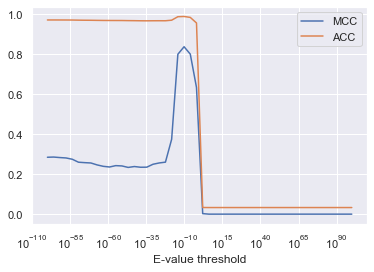

In [53]:
plot_MCC(p_train_vals, n_train_vals)

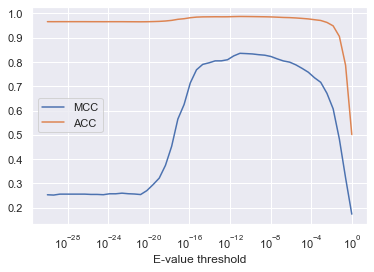

In [54]:
plot_MCC(p_train_vals, n_train_vals, -30, 0)

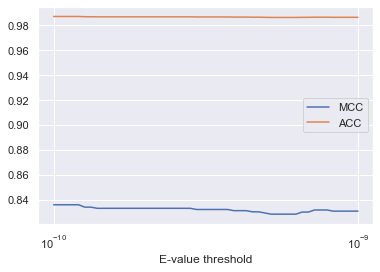

In [55]:
plot_MCC(p_train_vals, n_train_vals, -10, -9)

We can see that the MCC is near-random until 1e-27, then there is a sharp increase followed by a peak and a decrease.
We most probably want an MCC around 1e-10.
But let's determine it analitycally.

We could write down a simple univariate linear regression, but there is a function already available in scipy.
I just need to write a cost function in a form which can be used by the minimization algorithm.

In [56]:
import scipy.optimize as opt

def objective_fun_MCC(thr, p_vals, n_vals, mock=None): # mock is needed so that I don't get an error when I pass to it the windowsize parameter (see next)
    MCC = get_MCC(thr, p_vals, n_vals)
    cost = 1-abs(MCC)
    return cost

def maximize_MCC(p_vals, n_vals, fun_MCC, window_size=None):
    result = opt.minimize_scalar(fun_MCC, args=(p_vals, n_vals, window_size))
    optimal_thr = result.x
    return optimal_thr

In [57]:
training_thr = maximize_MCC(p_train_vals, n_train_vals, objective_fun_MCC)
"{:e}".format(training_thr) # just to print in scientific notation

'1.186242e-03'

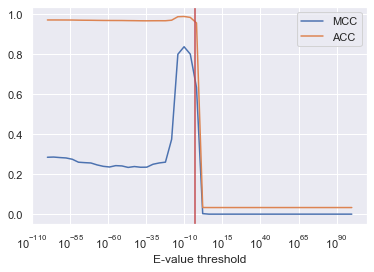

In [58]:
plot_MCC(p_train_vals, n_train_vals, -100, 100, training_thr)

This is NOT what I expected.
The function is really bumpy. I can make my algo work better by making it smoother with a sliding window.

In [59]:
def smoot_MCC(thr, p_vals, n_vals, window_size=1):
    x = thr
    log_x = np.log10(x)
    smooth_window = np.logspace(log_x-window_size/2,log_x+window_size/2)
    window_res = []
    for log_x_w in smooth_window:
        window_res.append(get_MCC(log_x_w, p_vals, n_vals))
    smooth_fun = -abs(sum(window_res)/len(window_res)) # need to be negative for minimization
    return smooth_fun


training_thr_smooth = maximize_MCC(p_train_vals, n_train_vals, smoot_MCC, 1) # smoothing with window size of 1
"{:e}".format(training_thr_smooth) # just to print in scientific notation

/home/saul/miniconda3/envs/LB1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/saul/miniconda3/envs/LB1/lib/python3.7/site-packages/numpy/core/function_base.py:142: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/home/saul/miniconda3/envs/LB1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/home/saul/miniconda3/envs/LB1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


'3.553190e-11'

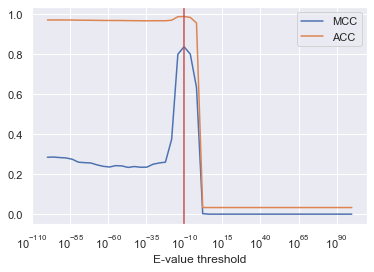

In [60]:
plot_MCC(p_train_vals, n_train_vals, -100, 100, training_thr_smooth)

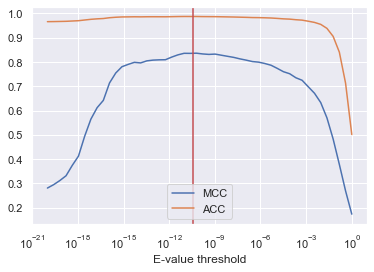

In [61]:
plot_MCC(p_train_vals, n_train_vals, -20, 0, training_thr_smooth)

Much better!

# Evaluation of the method on the test set
To evaluate how good my discrimination method is, I use the threshold of 1.18e-03 on the test set and determine the various statistics.
Just for simplicity I wrap all the various parsing operations in one function.

First I need to select the top-hits for each sequence also for the negative testing set.
The positive set is the same as the positive training set so it is not needed.

In [62]:
!cat negative_testing.bltab|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> negative_testing_topscores.bltab

Just for simplicity I wrap all the various parsing operations in one function

In [63]:
def get_vals(blast_filepath, fasta_filepath):
    df = get_blasttab_df(blast_filepath)
    with open(fasta_filepath) as fasta_file:
        num_seqs = 0
        for line in fasta_file:
            if line[0] == ">":
                num_seqs += 1
    vals = blast_complete_array(np.array(df[10]),num_seqs)
    return vals

Finally, let's see what happens!

In [64]:
n_test_vals = get_vals("./negative_testing_topscores.bltab","./human_SP_no_Kunitz_Testing.fasta")
p_test_vals = get_vals("./positive_training_testing_topscores.bltab","./no_human_SP_Kunitz.fasta")
get_stats(training_thr_smooth, p_test_vals, n_test_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[  331    57]
 [10290    10]] 

Threshold: 3.553189604039684e-11
ACC: 0.9937312874251497
MCC: 0.9068841113786128


My method shows an MCC of 0.907 on the testing set.
Here it is its placement with respect to other threshold values in the TESTING set.

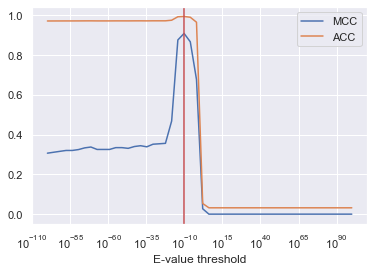

In [65]:
plot_MCC(p_test_vals, n_test_vals, -100, 100, training_thr_smooth)

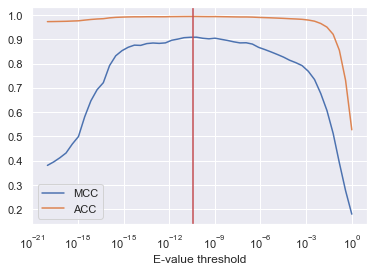

In [66]:
plot_MCC(p_test_vals, n_test_vals, -20, 0, training_thr_smooth)

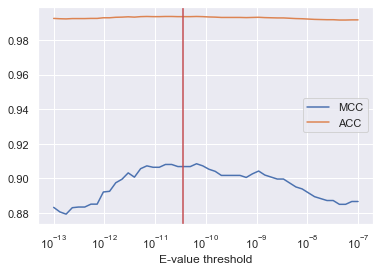

In [67]:
plot_MCC(p_test_vals, n_test_vals, -13, -7, training_thr_smooth)